In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def list_unzip_files(folder_path, unzip_dbf=False):
    # List all files in the folder
    all_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), folder_path)
            all_files.append(relative_path)
    # If there are any dbf zip files, unzip them
    if unzip_dbf:
        for file_path in files:
            if file_path.endswith('.zip'):
                if not os.path.exists(f"{folder_path}/{file_path[:-4]}"):
                    with zipfile.ZipFile(f"{folder_path}/{file_path}", 'r') as zip_ref:
                        zip_ref.extractall(folder_path)
    return all_files

In [3]:
def filter_data_border(data, path_to_border):
    # Load the shapefile containing the administrative borders of Ukraine
    ukraine_borders = gpd.read_file(path_to_border)
    # Ensure the data is a GeoDataFrame
    data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LONGITUDE, data.LATITUDE))
    # Set the same coordinate reference system (CRS) for both GeoDataFrames
    data_gdf.set_crs(epsg=4326, inplace=True)
    ukraine_borders.set_crs(epsg=4326, inplace=True)
    # Perform a spatial join to filter datapoints within Ukraine borders
    data_in_ukraine = gpd.sjoin(data_gdf, ukraine_borders, how='inner')
    # Drop the geometry column as it's no longer needed
    data_in_ukraine.drop(columns=['geometry', 'source', 'name', 'index_right'], inplace=True)
    # Reset the index
    data_in_ukraine.reset_index(drop=True, inplace=True)
    # Make sure all columns are in uppercase
    data_in_ukraine.columns = map(str.upper, data_in_ukraine.columns)
    # Rename the ID column to OBLAST_ID
    data_in_ukraine.rename(columns={'ID': 'OBLAST_ID'}, inplace=True)
    # Generate a unique identifier for each grid cell
    data_in_ukraine['GRID_CELL'] = data_in_ukraine['LATITUDE'].astype(str) + '_' + data_in_ukraine['LONGITUDE'].astype(str)
    return data_in_ukraine

In [4]:
def merge_dataframes(dataframes):
    # Merge the dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    # Drop rows that are not in the Ukraine borders
    merged_df = filter_data_border(merged_df, 'input_data/raw/ukr_borders/ua.shp')
    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

In [5]:
def plot_ukr_fires(data, path_to_border, title, colors=['red'], alphas=[0.25], markersizes=[1], legend=False, cmaps=[None], columns=[None]):
    # Load the shapefile containing the administrative borders of Ukraine
    ukraine_borders = gpd.read_file(path_to_border)
    # Ensure the data is a GeoDataFrame
    data_gdf = []
    for i in range(len(data)):
        data_gdf.append(gpd.GeoDataFrame(data[i], geometry=gpd.points_from_xy(data[i].LONGITUDE, data[i].LATITUDE)))
    # Set the same coordinate reference system (CRS) for all GeoDataFrames
    for i in range(len(data)):
        data_gdf[i].set_crs(epsg=4326, inplace=True)
    ukraine_borders.set_crs(epsg=4326, inplace=True)
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))
    ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
    for i in range(len(data)):
        if columns[i] is not None:
            data_gdf[i].plot(ax=ax, column=columns[i], cmap=cmaps[i], markersize=markersizes[i], alpha=alphas[i], legend=legend)
        else:
            data_gdf[i].plot(ax=ax, color=colors[i], markersize=markersizes[i], alpha=alphas[i], legend=legend)
    plt.title(title)
    plt.show()

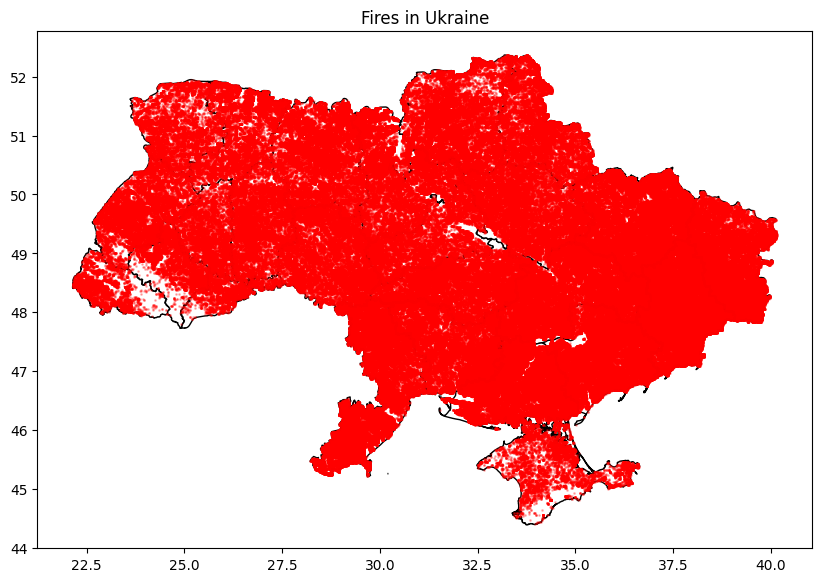

In [6]:
# Plot all fires in Ukraine
fire_data = [pd.read_csv('input_data/processed/fire_data.csv')]

plot_ukr_fires(fire_data, 'input_data/raw/ukr_borders/ua.shp', 'Fires in Ukraine', colors=['red'], alphas=[0.25], markersizes=[1])

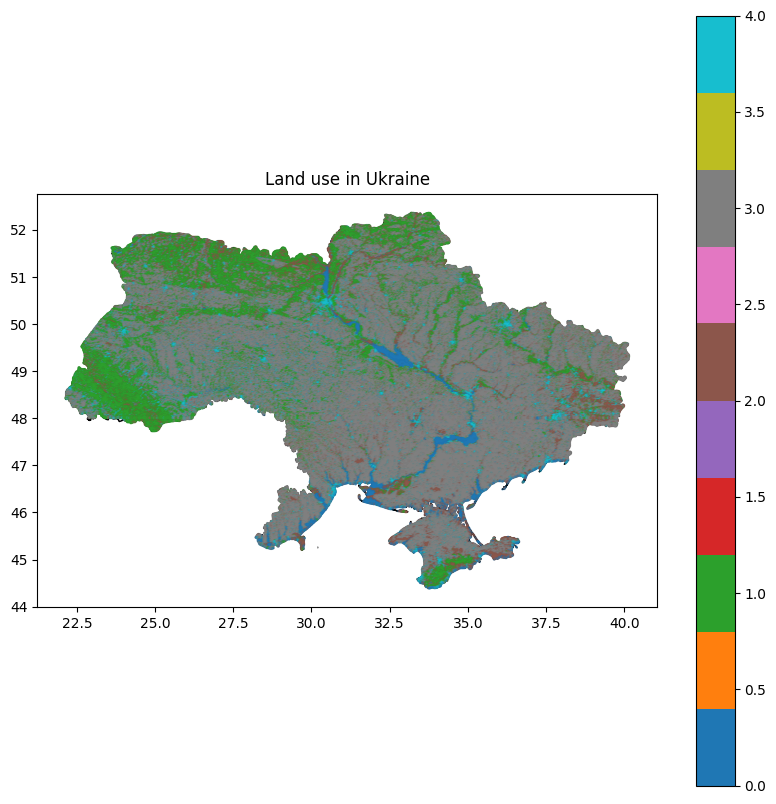

In [7]:
# Load all csv files in the folder
dataframes = []
for csv_file in list_unzip_files('input_data/processed'):
    if csv_file.endswith('001.csv') and csv_file[:-8] in [x[:-4] for x in list_unzip_files('input_data/raw/land_use')]:
        dataframes.append(pd.read_csv(f"input_data/processed/{csv_file}"))
# Merge the dataframes
land_use_data = [merge_dataframes(dataframes)]

plot_ukr_fires(land_use_data, 'input_data/raw/ukr_borders/ua.shp', 'Land use in Ukraine', cmaps=['tab10'], alphas=[0.25], markersizes=[1], columns=['CLASS'], legend=True)

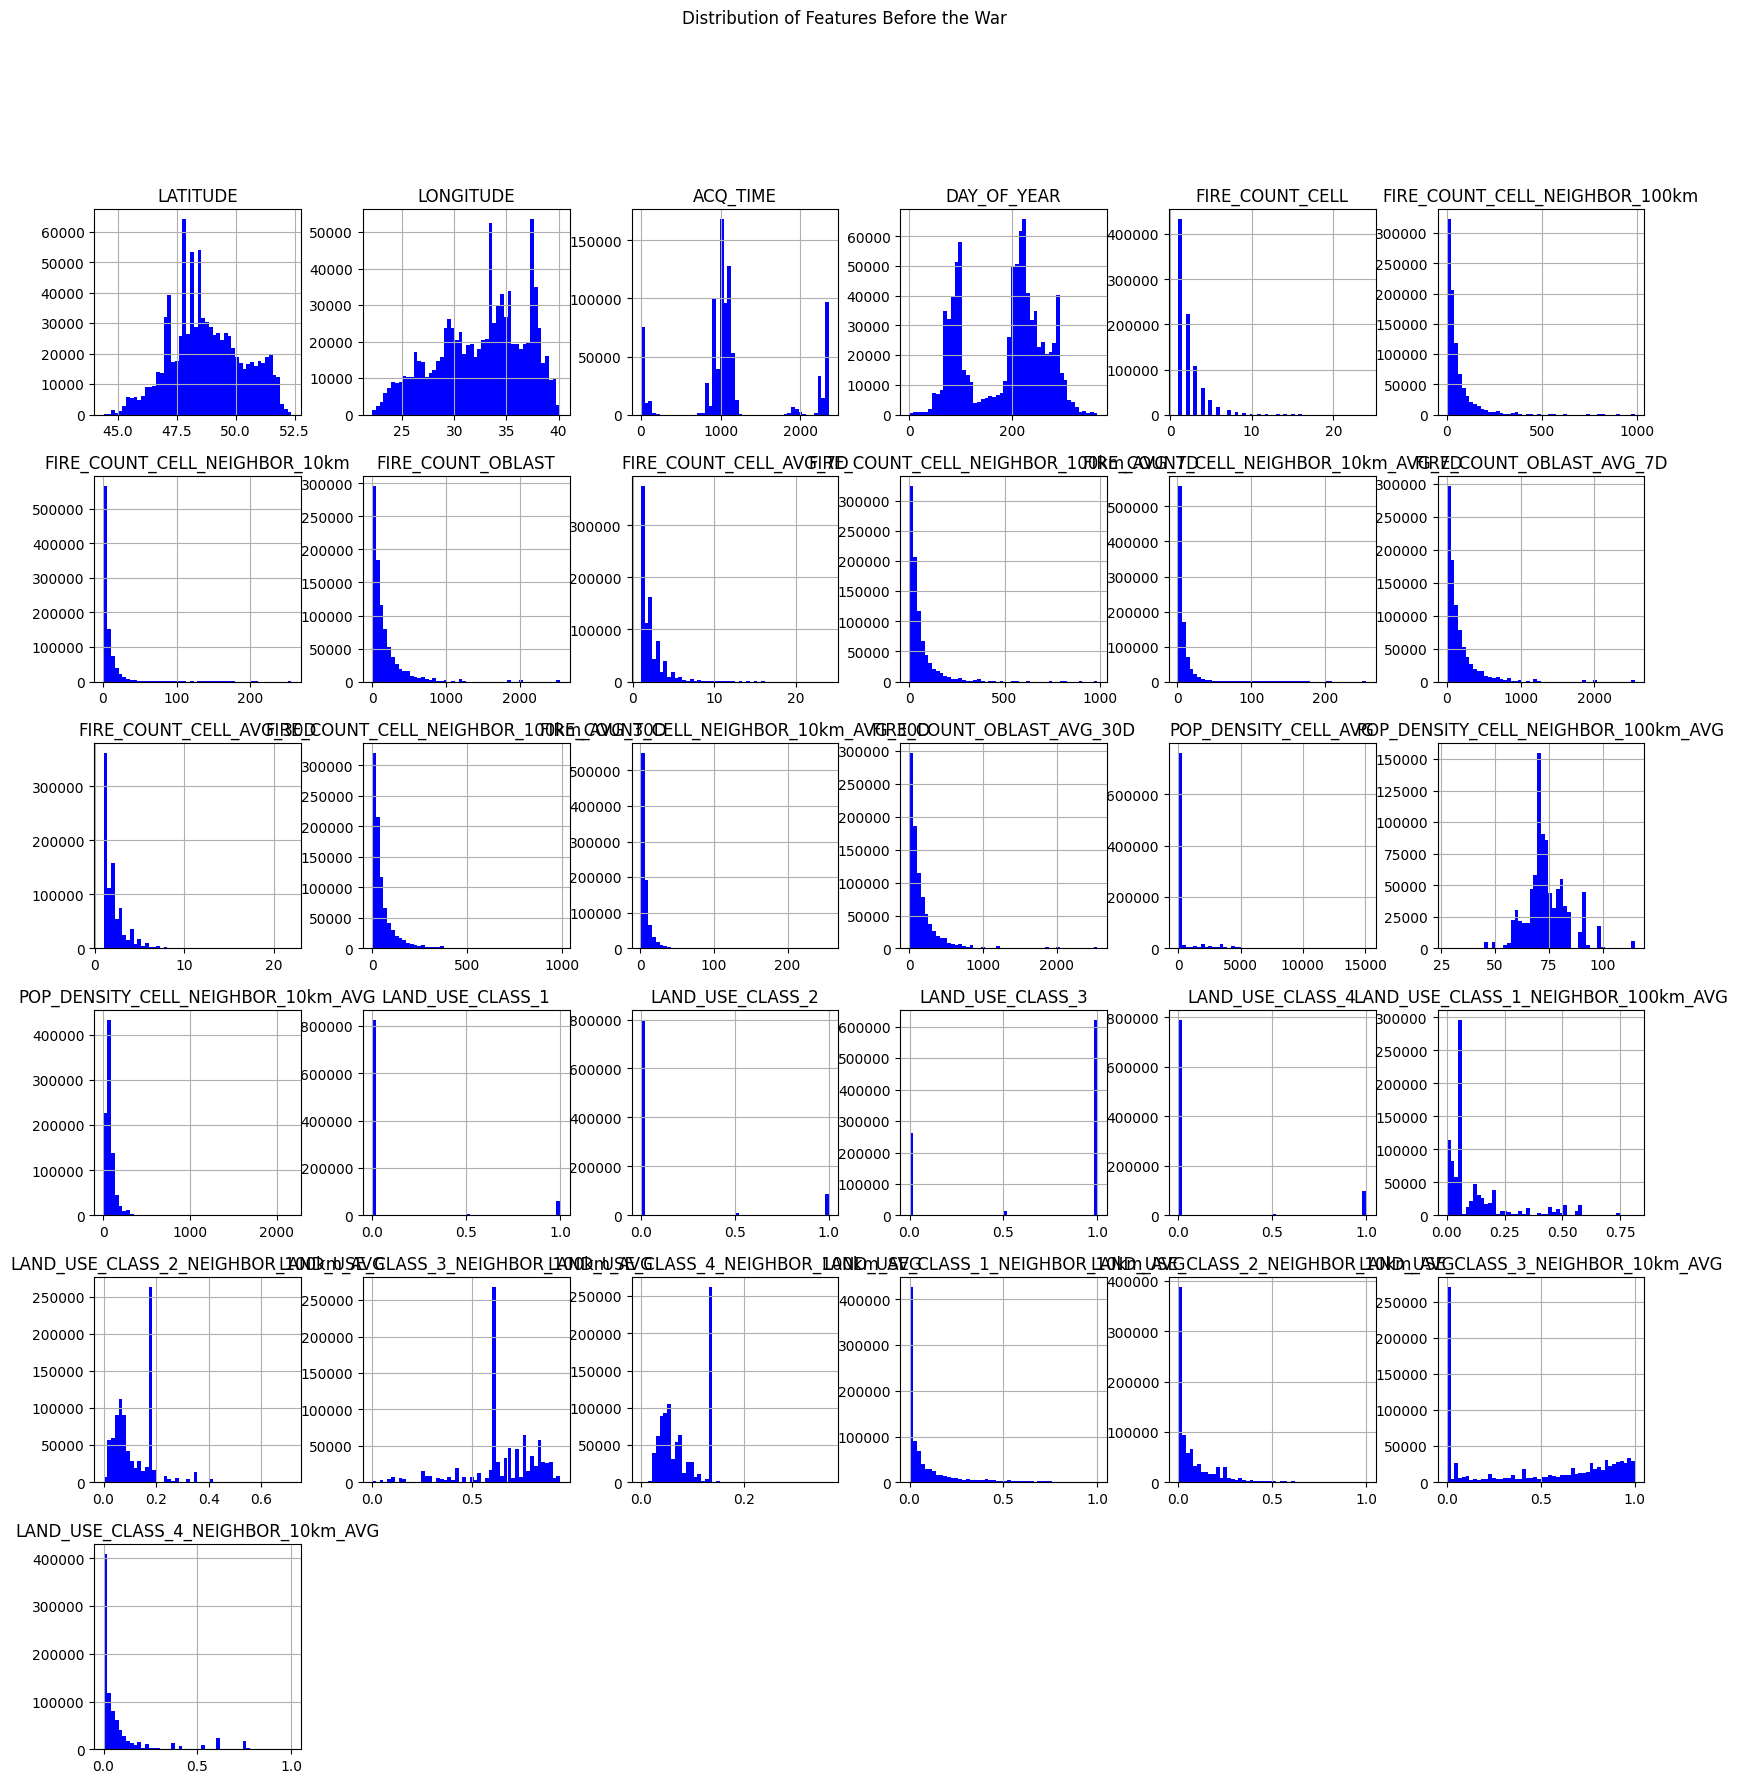

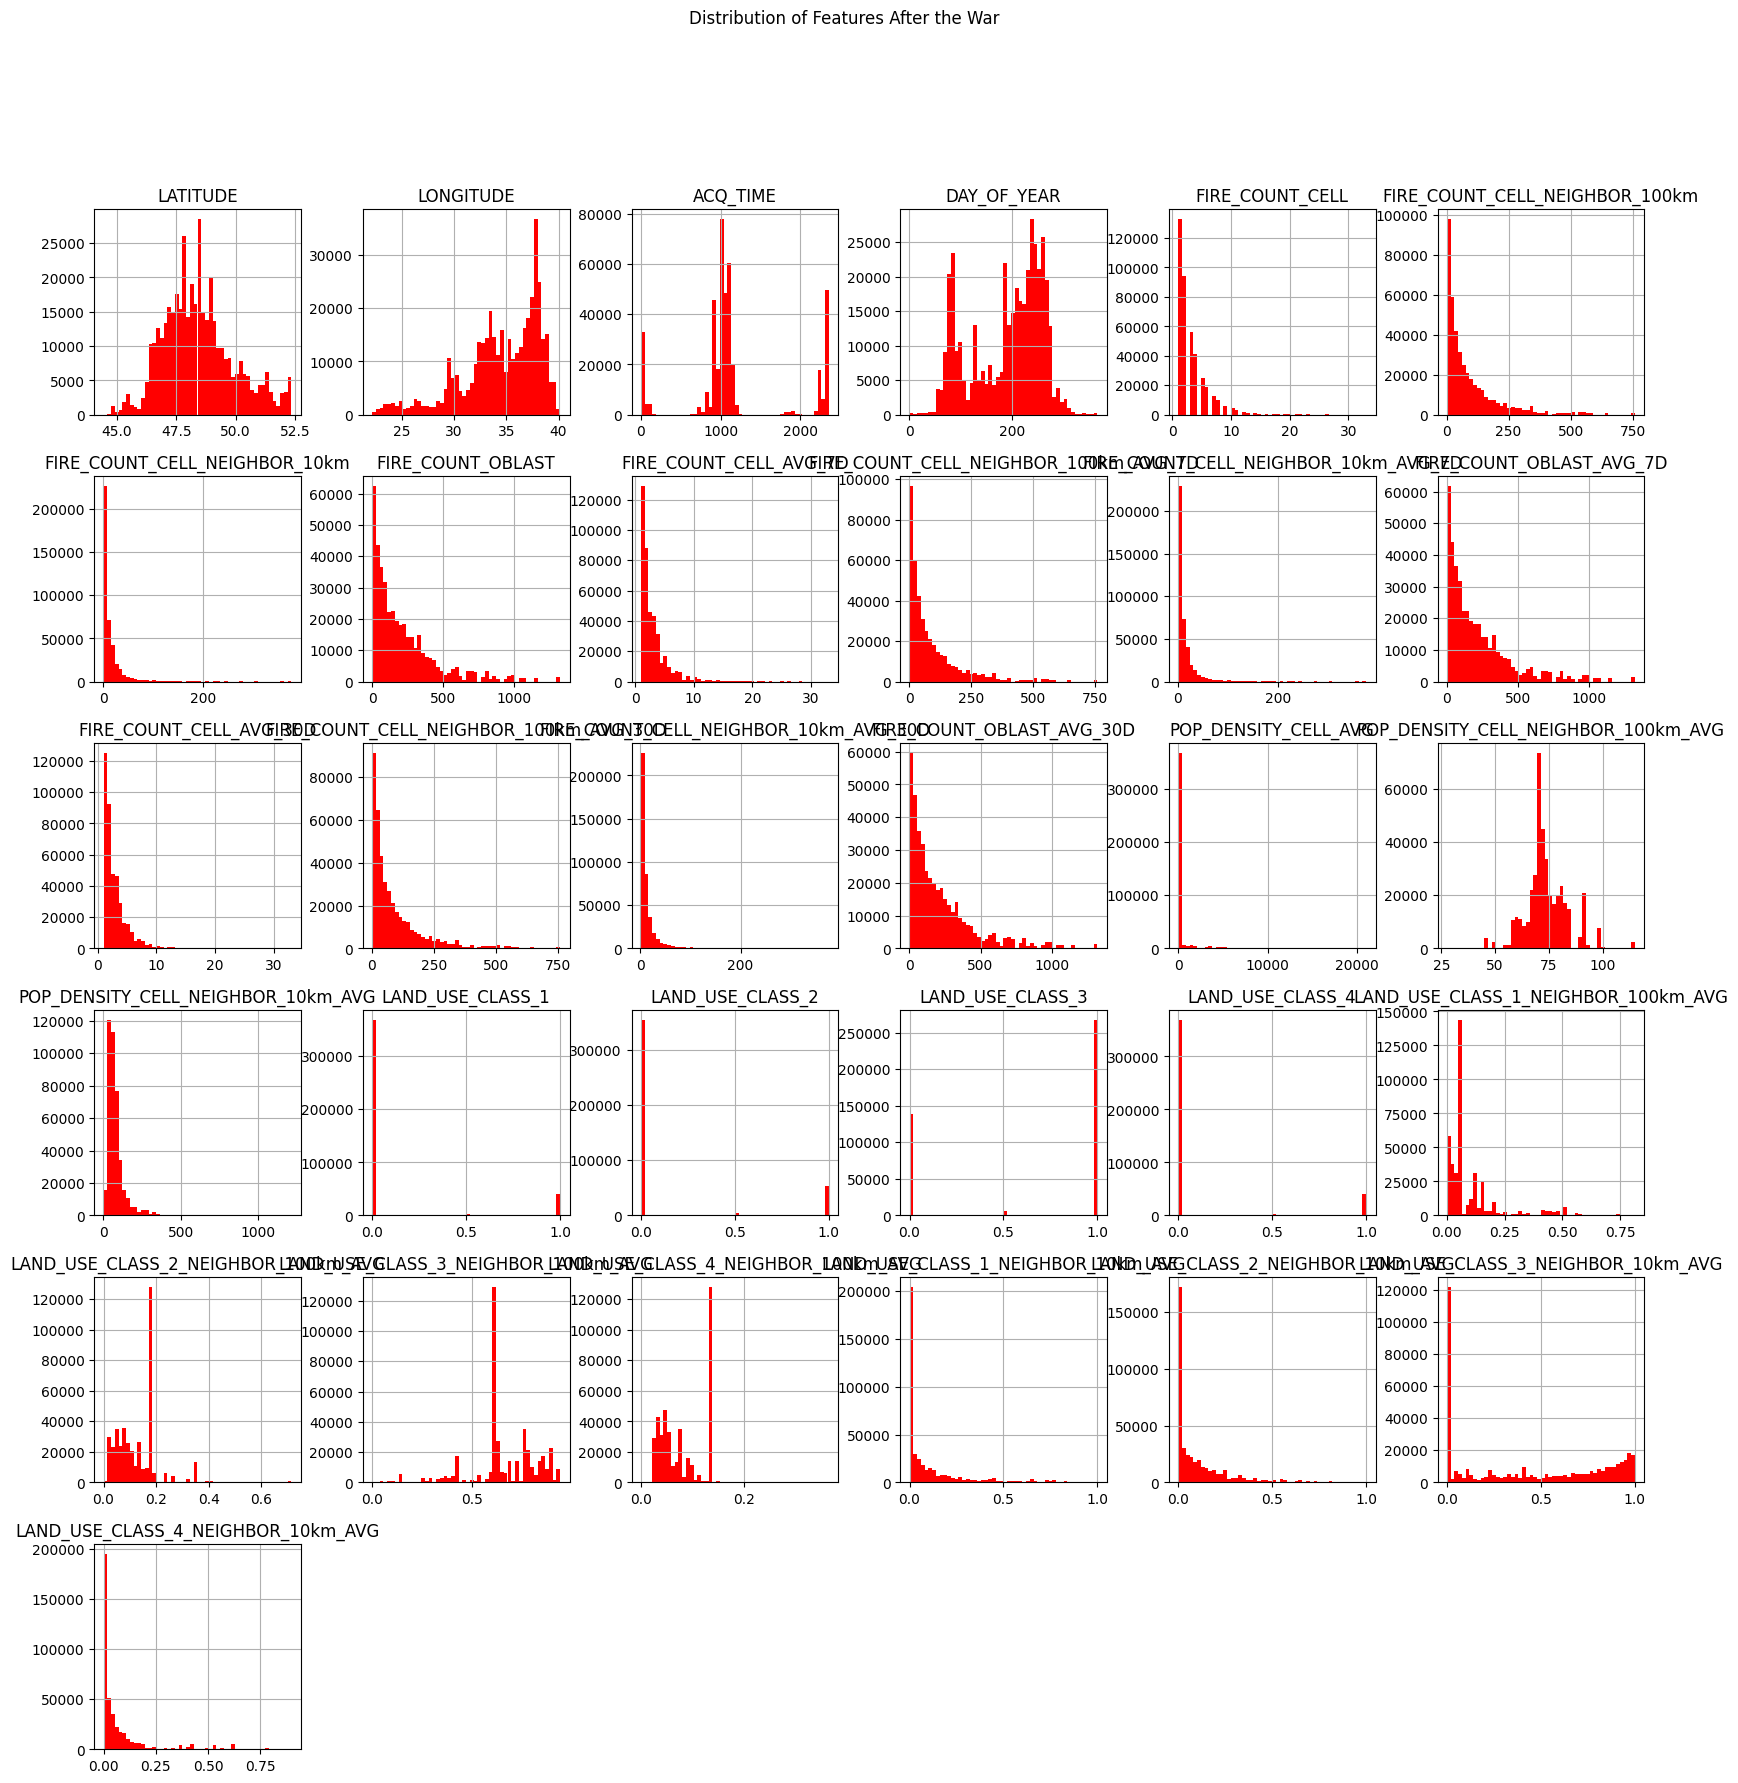

In [8]:
# Plot the distribution of features in the aggregated data for those rows with ACQ_DATE smaller than 2022-02-24 (the first day of the UKR war)
# and for those rows with ACQ_DATE greater than 2022-02-24

# Load the aggregated data
aggregated_data = pd.read_csv('input_data/processed/aggregated_data_001.csv')

# Filter the data
data_before_war = aggregated_data[aggregated_data['ACQ_DATE'] < '2022-02-24']
data_after_war = aggregated_data[aggregated_data['ACQ_DATE'] >= '2022-02-24']

# Plot the distribution of features, before and after the war
data_before_war.hist(figsize=(20, 20), color='blue', bins=50)
plt.suptitle('Distribution of Features Before the War')
plt.show()

data_after_war.hist(figsize=(20, 20), color='red', bins=50)
plt.suptitle('Distribution of Features After the War')
plt.show()